## 1.数据分析+数据预处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import xgboost as xgb
import os

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import joblib
from sklearn.ensemble import VotingRegressor

import warnings
# 关闭特定类型的警告
warnings.filterwarnings("ignore", category=UserWarning)

采用000016深康佳公司的数据进行预测，此处的股票数据已更新过，包含了2024年9月的股票数据

In [2]:
# 忽略warnings
import warnings
warnings.filterwarnings('ignore')

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

path = 'data/'
data = pd.read_csv(path + '000016深康佳Ａ.csv')

In [3]:
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   日期       501 non-null    object 
 1   开盘       501 non-null    float64
 2   收盘       501 non-null    float64
 3   涨跌额      501 non-null    float64
 4   涨跌幅      501 non-null    object 
 5   最低       501 non-null    float64
 6   最高       501 non-null    float64
 7   成交量(手)   501 non-null    int64  
 8   成交金额(万)  501 non-null    float64
 9   换手率      501 non-null    object 
dtypes: float64(6), int64(1), object(3)
memory usage: 39.3+ KB


(           日期    开盘    收盘   涨跌额     涨跌幅    最低    最高   成交量(手)   成交金额(万)    换手率
 0  2024-09-30  3.11  3.31  0.28   9.24%  3.03  3.32  1220325  39156.35  7.64%
 1  2024-09-27  2.94  3.03  0.11   3.77%  2.92  3.10   997023  29919.40  6.24%
 2  2024-09-26  2.85  2.92  0.05   1.74%  2.82  2.93   795939  23090.30  4.99%
 3  2024-09-25  2.90  2.87 -0.03  -1.03%  2.83  2.97  1026790  29782.44  6.43%
 4  2024-09-24  2.97  2.90  0.02   0.69%  2.79  2.97  1318475  37882.04  8.26%,
 None)

In [4]:
data.shape

(501, 10)

In [5]:
data.describe()

,开盘,收盘,涨跌额,最低,最高,成交量(手),成交金额(万)
count,501.000000,501.000000,501.000000,501.000000,501.000000,5.010000e+02,501.000000
mean,4.035050,4.030439,-0.004731,3.974072,4.095409,2.091469e+05,7409.278044
std,0.968421,0.964283,0.087994,0.969116,0.962947,2.549129e+05,7476.854214
min,1.950000,1.930000,-0.350000,1.870000,1.980000,4.782900e+04,2189.170000
25%,3.140000,3.140000,-0.060000,3.100000,3.260000,9.064400e+04,3708.260000
50%,4.340000,4.330000,-0.010000,4.300000,4.380000,1.216080e+05,4996.620000
75%,4.810000,4.810000,0.040000,4.760000,4.870000,2.004600e+05,7175.730000
max,5.750000,5.700000,0.380000,5.640000,5.780000,2.114670e+06,66499.240000


In [6]:
# 查看缺失值
data.isnull().sum()

日期         0
开盘         0
收盘         0
涨跌额        0
涨跌幅        0
最低         0
最高         0
成交量(手)     0
成交金额(万)    0
换手率        0
dtype: int64

<Axes: >

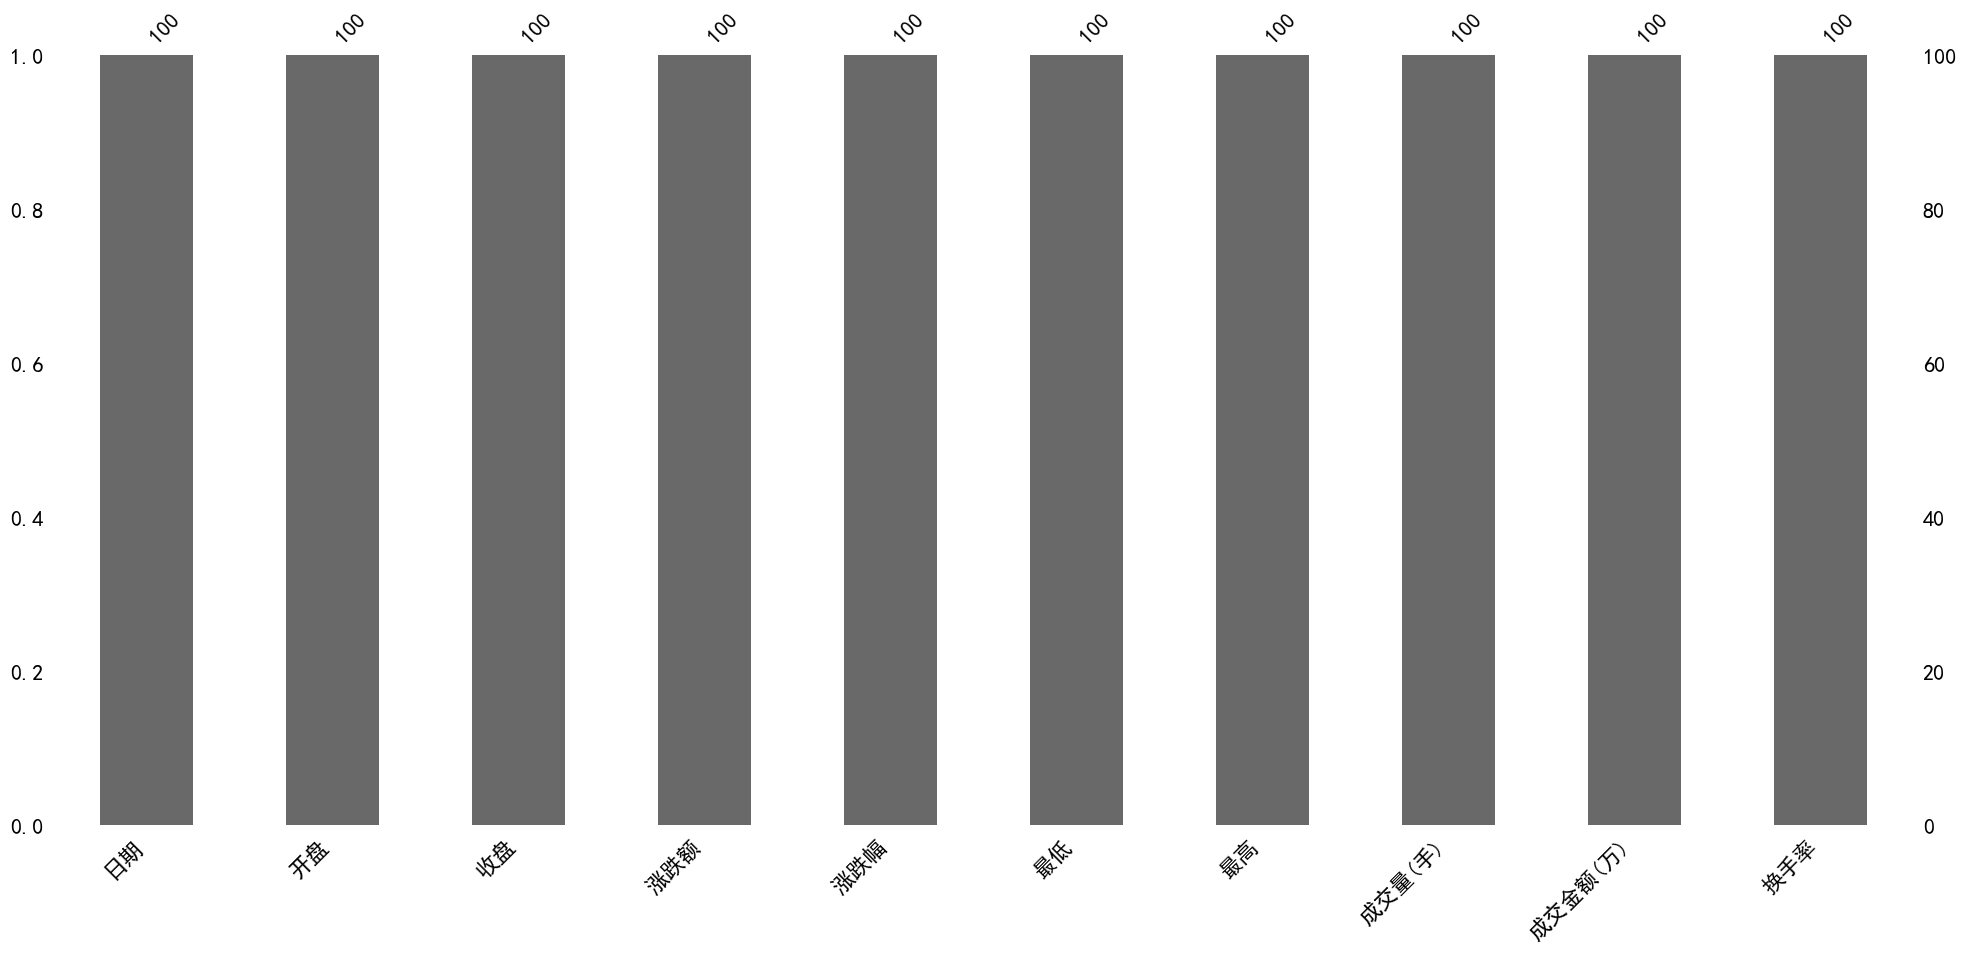

In [7]:
# 都没有缺失值，不需要处理缺失值
msno.bar(data.sample(100))

In [8]:
# 把日期转换为时间格式
data['日期'] = pd.to_datetime(data['日期'])
data['日期'].head()

0   2024-09-30
1   2024-09-27
2   2024-09-26
3   2024-09-25
4   2024-09-24
Name: 日期, dtype: datetime64[ns]

<Axes: title={'center': 'Log Normal'}, xlabel='最高'>

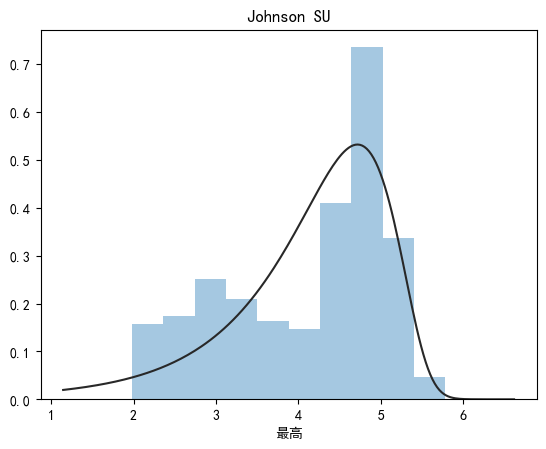

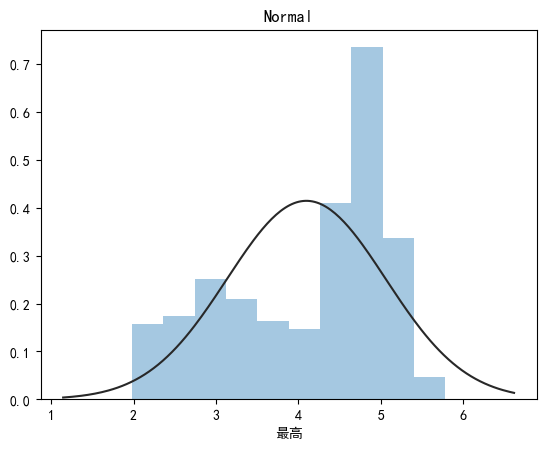

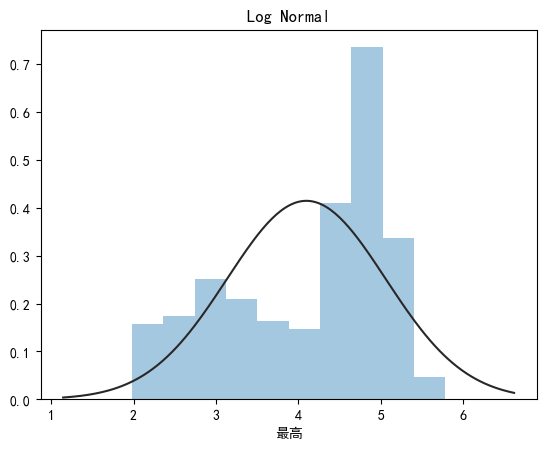

In [9]:
import scipy.stats as st
y = data['最高']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

可以看出，最高价大致满足正态分布，所以之后可以不用对其进行正态化处理

<Axes: title={'center': 'Log Normal'}, xlabel='最低'>

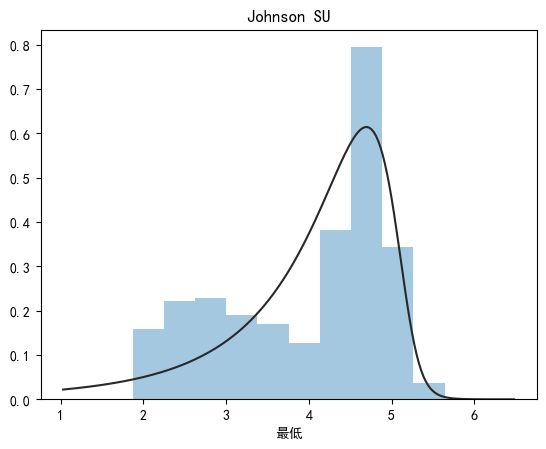

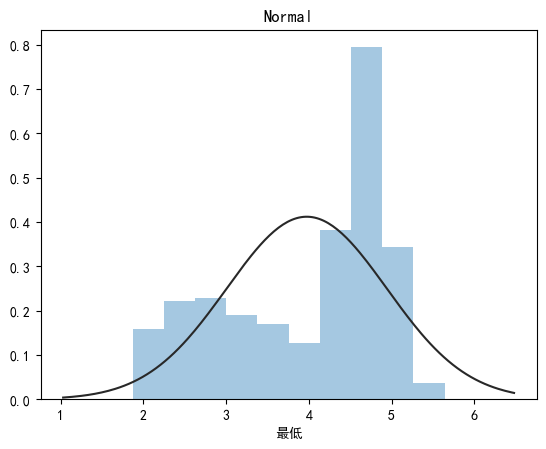

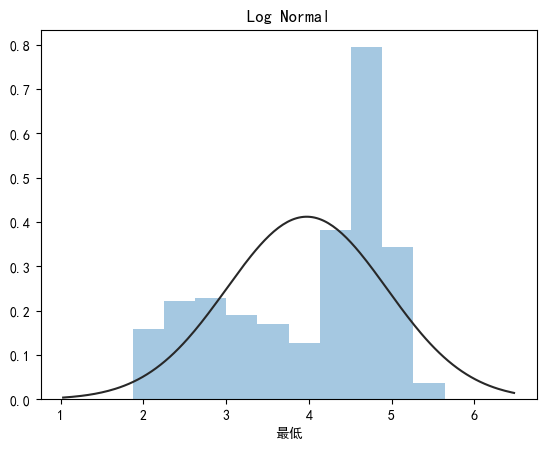

In [10]:
import scipy.stats as st
y = data['最低']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

Skewness: -0.605851
Kurtosis: -0.901837


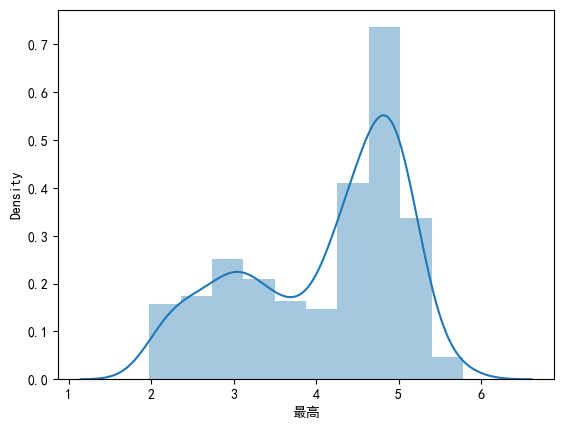

In [11]:
# 查看数据的偏度和峰度
sns.distplot(data['最高'])
print("Skewness: %f" % data['最高'].skew())
print("Kurtosis: %f" % data['最高'].kurt())

偏度值<0,说明数据较为左偏；峰度值的绝对值在3以内，说明数据较为平坦，并且都在可接受范围之内

In [12]:
# 去除"涨跌幅"和"换手率"列中的百分号并转换为浮点数
data['涨跌幅'] = data['涨跌幅'].str.rstrip('%').astype(float)
data['换手率'] = data['换手率'].str.rstrip('%').astype(float)

# 只对数值列计算偏度和峰度
numeric_cols = data.select_dtypes(include=[np.number])
numeric_cols.skew(), numeric_cols.kurt()

(开盘        -0.616654
 收盘        -0.615266
 涨跌额        0.298285
 涨跌幅        0.627539
 最低        -0.619337
 最高        -0.605851
 成交量(手)     3.719064
 成交金额(万)    3.680503
 换手率        3.718670
 dtype: float64,
 开盘         -0.925223
 收盘         -0.939206
 涨跌额         2.243745
 涨跌幅         4.744220
 最低         -0.958284
 最高         -0.901837
 成交量(手)     17.182470
 成交金额(万)    17.739348
 换手率        17.179537
 dtype: float64)

由于特征全部为数字特征，所以只进行数字特征的处理

In [13]:
data.columns

Index(['日期', '开盘', '收盘', '涨跌额', '涨跌幅', '最低', '最高', '成交量(手)', '成交金额(万)', '换手率'], dtype='object')

In [14]:
features = ['最高', '最低', '开盘', '收盘', '涨跌幅', '换手率', '成交量(手)', '成交金额(万)']

In [15]:
# 查看特征之间的相关性
price_numeric = data[features]
correlation = price_numeric.corr()
print(correlation['最高'].sort_values(ascending = False),'\n')

最高         1.000000
收盘         0.998204
开盘         0.997728
最低         0.997460
涨跌幅       -0.015856
成交金额(万)   -0.187590
成交量(手)    -0.396686
换手率       -0.396765
Name: 最高, dtype: float64 



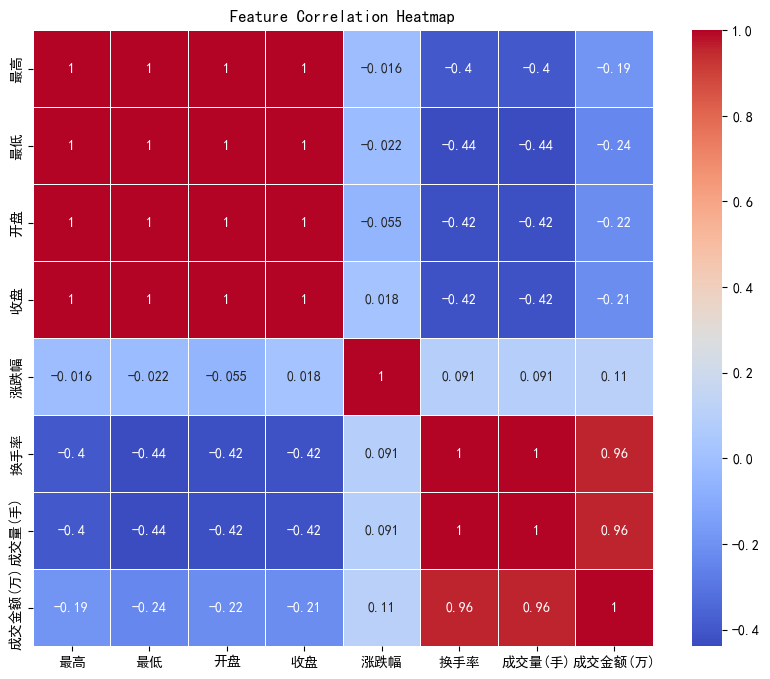

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

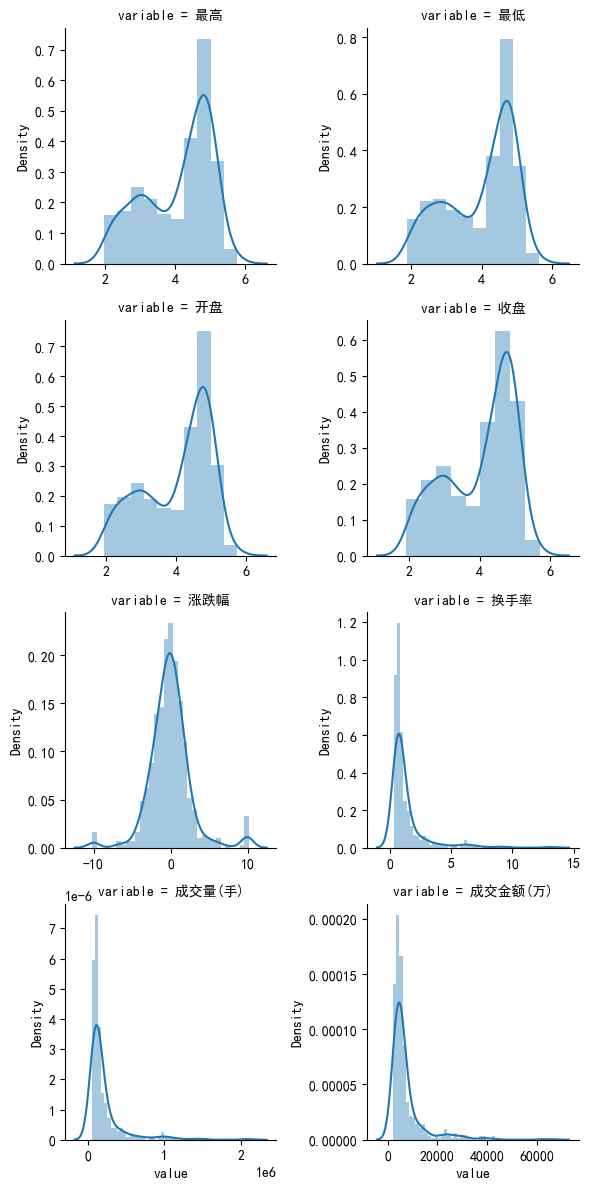

In [17]:
# 每个数字特征的分布可视化
f = pd.melt(data, value_vars = features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

由于发现收盘、开盘这两个变量与最高相关性过高，很可能会导致数据的过拟合，因此删除该两个变量。而涨跌幅相关性又过低，因此删除

In [18]:
data = data.drop(columns=['收盘', '开盘', '涨跌幅'])
data.head()

,日期,涨跌额,最低,最高,成交量(手),成交金额(万),换手率
0,2024-09-30,0.28,3.03,3.32,1220325,39156.35,7.64
1,2024-09-27,0.11,2.92,3.10,997023,29919.40,6.24
2,2024-09-26,0.05,2.82,2.93,795939,23090.30,4.99
3,2024-09-25,-0.03,2.83,2.97,1026790,29782.44,6.43
4,2024-09-24,0.02,2.79,2.97,1318475,37882.04,8.26


## 2.特征工程

查看数据最高和最低列的箱线图，删除异常值

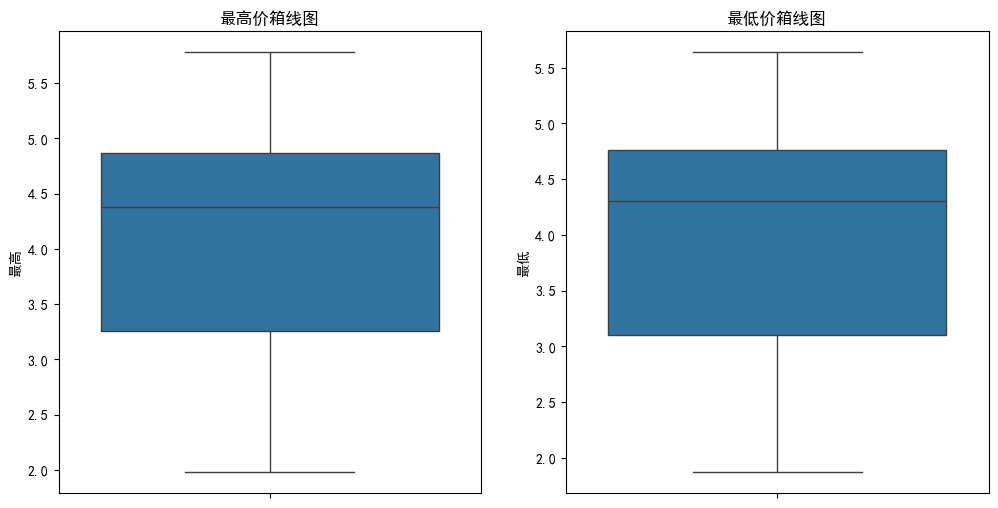

(501, 7)

In [19]:
# 绘制箱线图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=data['最高'])
plt.title('最高价箱线图')

plt.subplot(1, 2, 2)
sns.boxplot(y=data['最低'])
plt.title('最低价箱线图')

plt.show()

# 删除异常值
Q1 = data[['最高', '最低']].quantile(0.25)
Q3 = data[['最高', '最低']].quantile(0.75)
IQR = Q3 - Q1

data = data[~((data[['最高', '最低']] < (Q1 - 1.5 * IQR)) | (data[['最高', '最低']] > (Q3 + 1.5 * IQR))).any(axis=1)]
data.shape

数据没有异常值，说明比较接近理想数据，接下来进行特征构造

In [20]:
# 构造特征：成交量变化率
data['成交量变化率'] = data['成交量(手)'].pct_change()
data['成交量变化率'].head()

0         NaN
1   -0.182986
2   -0.201684
3    0.290036
4    0.284075
Name: 成交量变化率, dtype: float64

In [21]:
data['波动率'] = (data['最高'] - data['最低']) / data['最低']

In [22]:
data['成交量金额比'] = data['成交量(手)'] / data['成交金额(万)']

In [23]:
data.head()

,日期,涨跌额,最低,最高,成交量(手),成交金额(万),换手率,成交量变化率,波动率,成交量金额比
0,2024-09-30,0.28,3.03,3.32,1220325,39156.35,7.64,NaN,0.095710,31.165443
1,2024-09-27,0.11,2.92,3.10,997023,29919.40,6.24,-0.182986,0.061644,33.323629
2,2024-09-26,0.05,2.82,2.93,795939,23090.30,4.99,-0.201684,0.039007,34.470708
3,2024-09-25,-0.03,2.83,2.97,1026790,29782.44,6.43,0.290036,0.049470,34.476356
4,2024-09-24,0.02,2.79,2.97,1318475,37882.04,8.26,0.284075,0.064516,34.804752


由于特征构造设计前一个数据，因此表中第一行数据必然是缺失，将其删除

In [24]:
data = data.dropna()
data.shape

(500, 10)

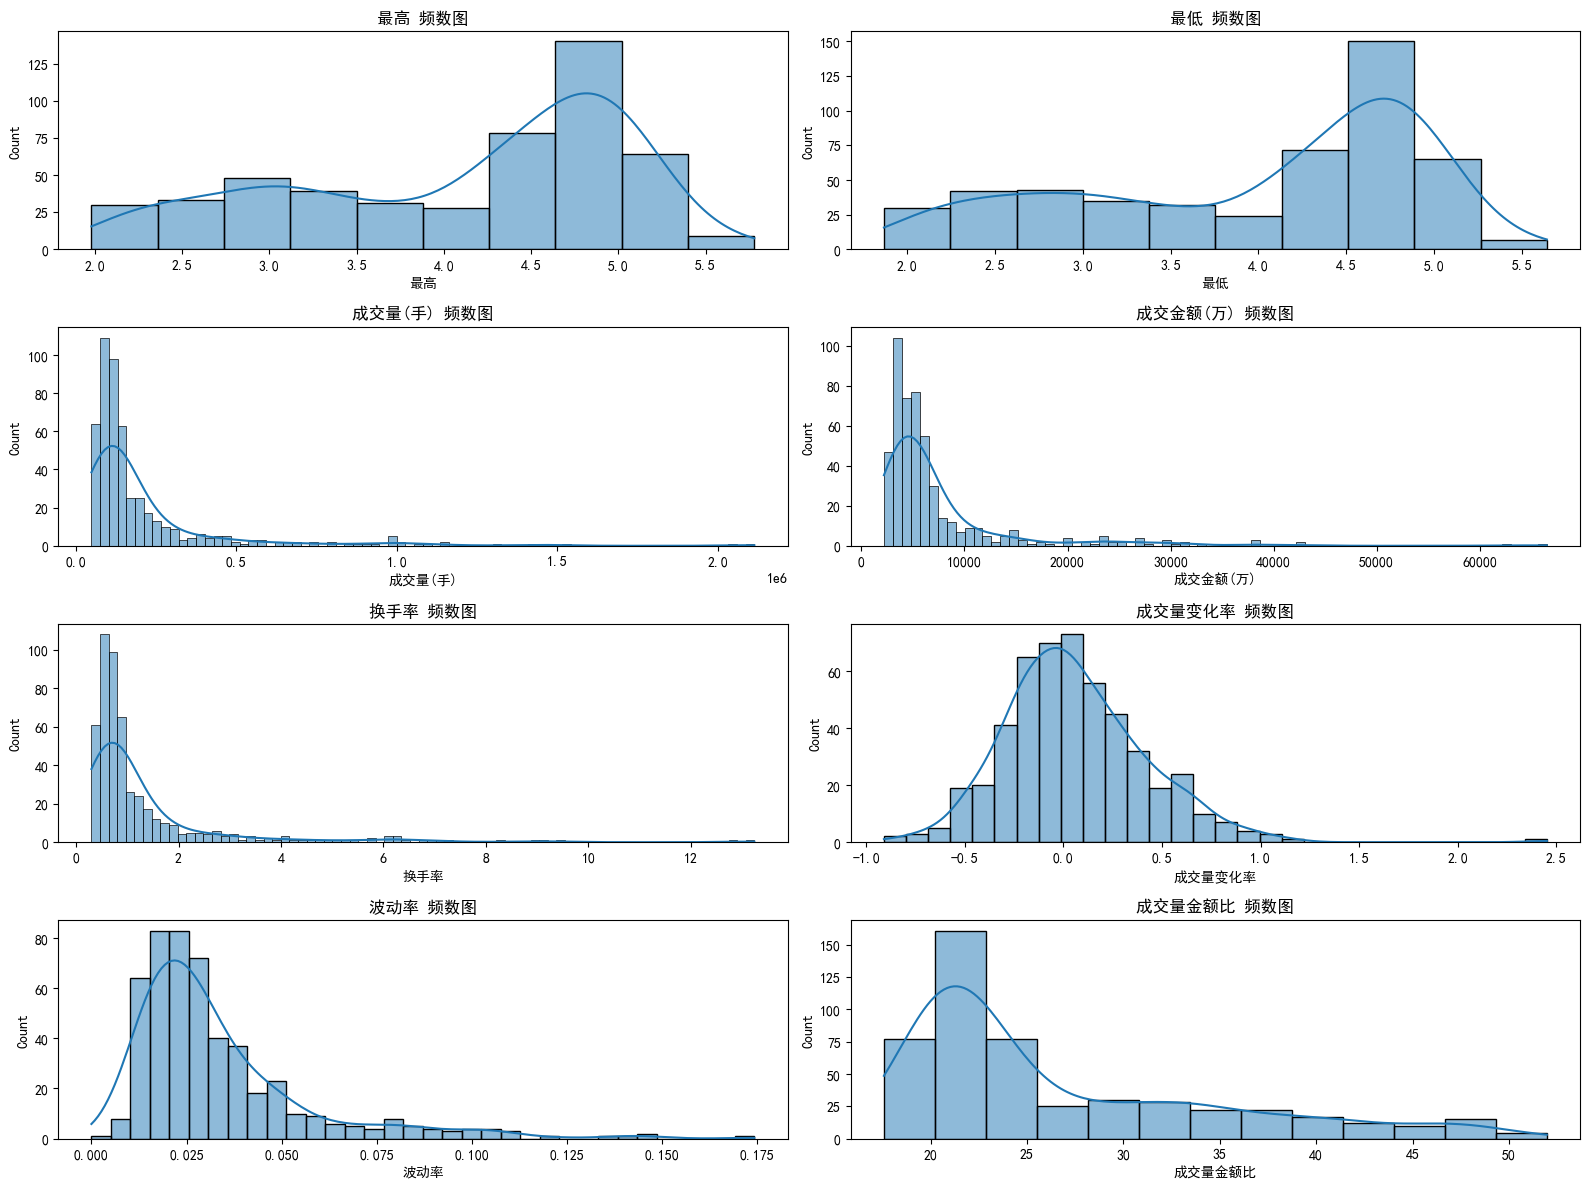

In [25]:
# 画出所有特征的频数图
features = ['最高', '最低', '成交量(手)', '成交金额(万)', '换手率', '成交量变化率', '波动率', '成交量金额比']
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features):
    plt.subplot(4, 2, i + 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'{feature} 频数图')

plt.tight_layout()
plt.show()

由于成交量，成交金额，换手率偏度较大，采用对数变换处理

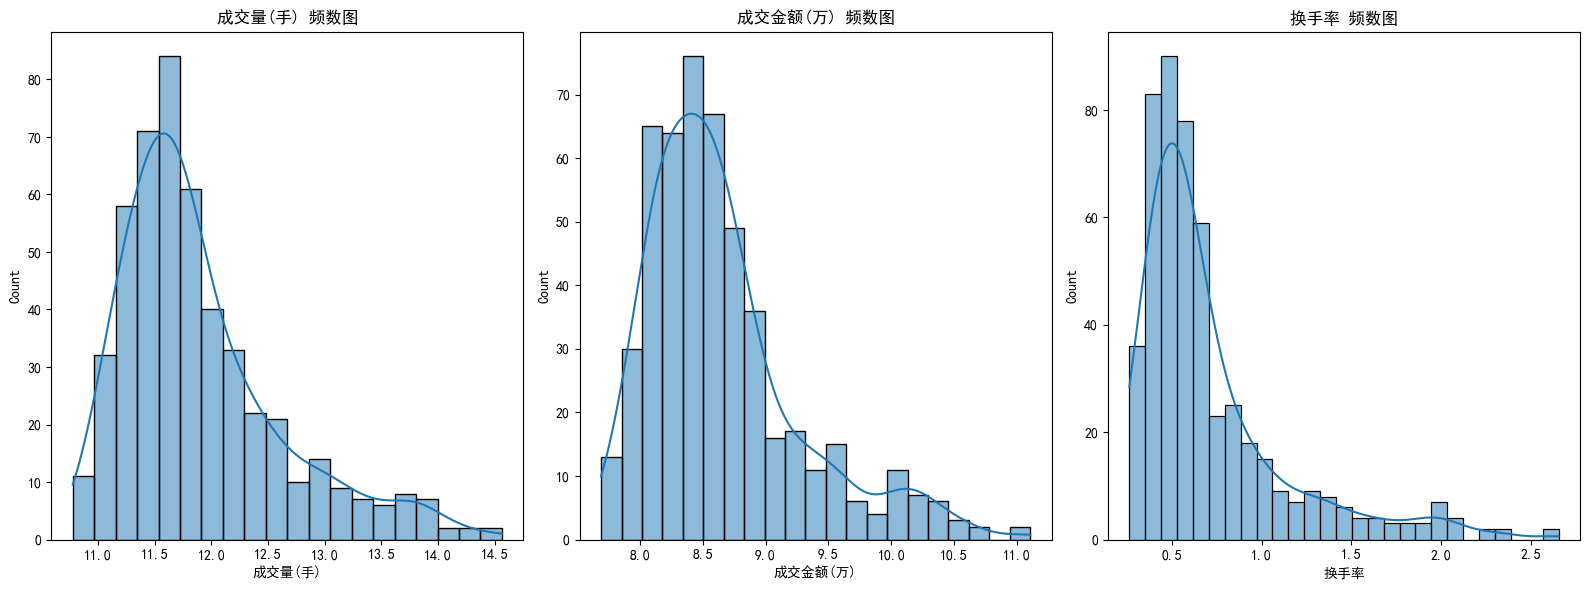

In [26]:
# log1p即为log(x+1)
data['成交量(手)'] = np.log1p(data['成交量(手)'])
data['成交金额(万)'] = np.log1p(data['成交金额(万)'])
data['换手率'] = np.log1p(data['换手率'])

plt.figure(figsize=(16, 6))

for i, feature in enumerate(['成交量(手)', '成交金额(万)', '换手率']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'{feature} 频数图')

plt.tight_layout()
plt.show()

## 3.建模调参

In [27]:
# 将数据分为训练集和测试集，其中训练集是2024年9月之前的数据
train_data = data[data['日期'] < '2024-09-01']
test_data = data[data['日期'] >= '2024-09-01']

print("训练集大小:", train_data.shape)
print("测试集大小:", test_data.shape)

训练集大小: (482, 10)
测试集大小: (18, 10)


In [28]:
y_train_high = train_data['最高']
y_train_low = train_data['最低']
y_test_high = test_data['最高']
y_test_low = test_data['最低']

X_train = train_data.drop(columns=['日期', '最高', '最低'])
X_test = test_data.drop(columns=['日期', '最高', '最低'])

In [29]:
from sklearn.linear_model import LinearRegression

model_high = LinearRegression()
model_high.fit(X_train, y_train_high)

LinearRegression()

In [30]:
# 输出权重
coefficients = model_high.coef_
features = X_train.columns

for feature, coef in zip(features, coefficients):
    print(f'{feature}: {coef}')

涨跌额: -0.15125725956804245
成交量(手): -6.904843250160778
成交金额(万): 6.9518746628614805
换手率: -0.05755947823245866
成交量变化率: -0.005149597101684833
波动率: 1.6984212944464667
成交量金额比: 0.11206742240268408


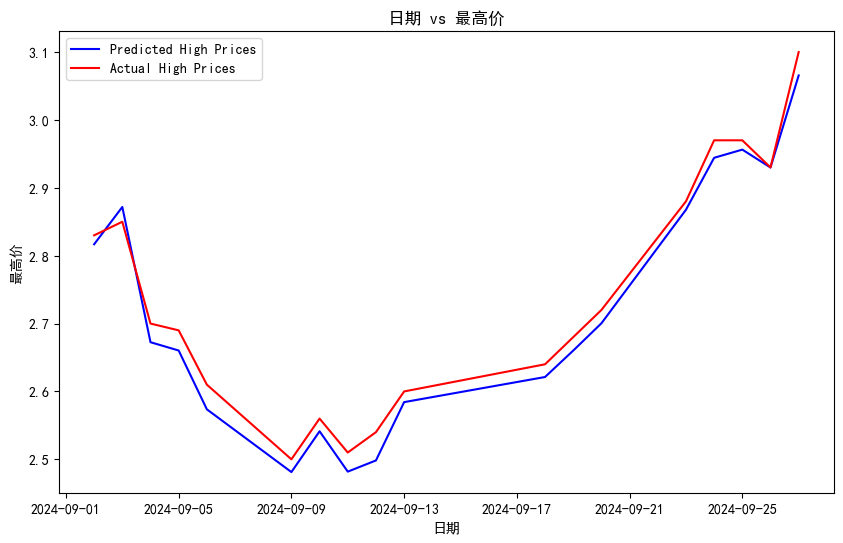

In [31]:
# 预测测试集的最高价
y_pred_high = model_high.predict(X_test)

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.plot(test_data['日期'], y_pred_high, color='blue', label='Predicted High Prices')
plt.plot(test_data['日期'], y_test_high, color='red', label='Actual High Prices')
plt.xlabel('日期')
plt.ylabel('最高价')
plt.title('日期 vs 最高价')
plt.legend()
plt.show()

## xgboost

尝试训练，以一个股票做训练集，预测该股票未来一月``最高价``和``最低价``

In [32]:
# 设置参数网格
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],  # L1 正则化
    'reg_lambda': [1, 1.5, 2]  # L2 正则化
}

# 创建 XGBoost 模型
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# 使用 GridSearchCV 进行参数搜索
grid_search_high = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search_high.fit(X_train, y_train_high)

grid_search_low = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search_low.fit(X_train, y_train_low)

# 获取最佳参数和模型
best_params_high = grid_search_high.best_params_
best_model_high = grid_search_high.best_estimator_

best_params_low = grid_search_low.best_params_
best_model_low = grid_search_low.best_estimator_

print(f'Best parameters found: {best_params_high}')
print(f'Best parameters found: {best_params_low}')

# 使用最佳模型进行预测和评估
y_pred = best_model_high.predict(X_test)
mse = mean_squared_error(y_test_high, y_pred)
print(f'Mean Squared Error: {mse}')

y_pred = best_model_low.predict(X_test)
mse = mean_squared_error(y_test_low, y_pred)
print(f'Mean Squared Error: {mse}')

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 1.0}
Mean Squared Error: 0.0019518103608453438
Mean Squared Error: 0.0013189009250873


下方展示 ``预测最高价`` 和 ``实际最高价``

Mean Squared Error: 0.025418806002703697


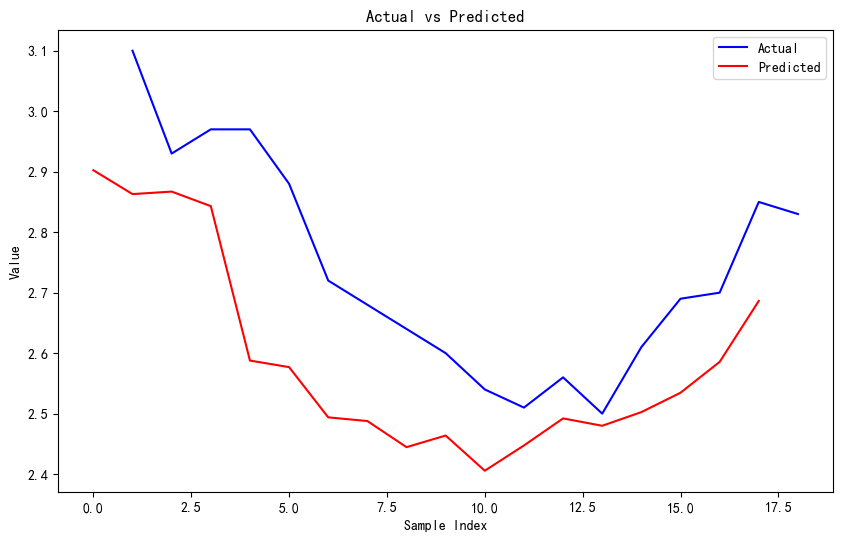

In [33]:
y_pred = best_model_low.predict(X_test)
mse = mean_squared_error(y_test_high, y_pred)
print(f'Mean Squared Error: {mse}')

# 绘制实际值和预测值的折线图
plt.figure(figsize=(10, 6))

# 绘制实际值
plt.plot(y_test_high, label='Actual', color='blue')

# 绘制预测值
plt.plot(y_pred, label='Predicted', color='red')

# 添加标题和标签
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

通过上面得到的模型，预测其他股票，输出 ``MSE``

*此处仍在探索方法，为节省时间只预测最高价*

In [34]:
with open('data/filename', 'r') as file:
    file_names = file.read().splitlines()

In [35]:
def deal_data(data):
    data['日期'] = pd.to_datetime(data['日期'])

    data['涨跌幅'] = data['涨跌幅'].str.rstrip('%').astype(float)
    data['换手率'] = data['换手率'].str.rstrip('%').astype(float)

    data = data.drop(columns=['收盘', '开盘', '涨跌幅'])

    # # 删除异常值
    # Q1 = data[['最高', '最低']].quantile(0.25)
    # Q3 = data[['最高', '最低']].quantile(0.75)
    # IQR = Q3 - Q1

    # data = data[~((data[['最高', '最低']] < (Q1 - 1.5 * IQR)) | (data[['最高', '最低']] > (Q3 + 1.5 * IQR))).any(axis=1)]

    data['成交量变化率'] = data['成交量(手)'].pct_change()

    data['波动率'] = (data['最高'] - data['最低']) / data['最低']

    data['成交量金额比'] = data['成交量(手)'] / data['成交金额(万)']

    data = data.dropna()

    data['成交量(手)'] = np.log1p(data['成交量(手)'])
    data['成交金额(万)'] = np.log1p(data['成交金额(万)'])
    data['换手率'] = np.log1p(data['换手率'])

    train_data = data[data['日期'] < '2024-09-01']
    test_data = data[data['日期'] >= '2024-09-01']

    return train_data, test_data



000016深康佳Ａ.csv - Mean Squared Error: 0.025418806002703697
000021深科技.csv - Mean Squared Error: 65.49851578851322
000818航锦科技.csv - Mean Squared Error: 95.61879014973046
001309德明利.csv - Mean Squared Error: 3910.497278997448
002049紫光国微.csv - Mean Squared Error: 1818.8101585611523
002077大港股份.csv - Mean Squared Error: 32.227458890785414
002119康强电子.csv - Mean Squared Error: 26.593638056748322
002183怡亚通.csv - Mean Squared Error: 0.023507017401557313
002185华天科技.csv - Mean Squared Error: 4.81718761276626
002213大为股份.csv - Mean Squared Error: 17.977551904011328
002409雅克科技.csv - Mean Squared Error: 2165.806772870301
002413雷科防务.csv - Mean Squared Error: 0.009880194664740891
002559亚威股份.csv - Mean Squared Error: 2.653588800729834
002579中京电子.csv - Mean Squared Error: 2.105435947420251
002654万润科技.csv - Mean Squared Error: 15.763635752596688
300042朗科科技.csv - Mean Squared Error: 128.12370073554368
300053航宇微.csv - Mean Squared Error: 16.95019504378577
300131英唐智控.csv - Mean Squared Error: 0.1291304336039452

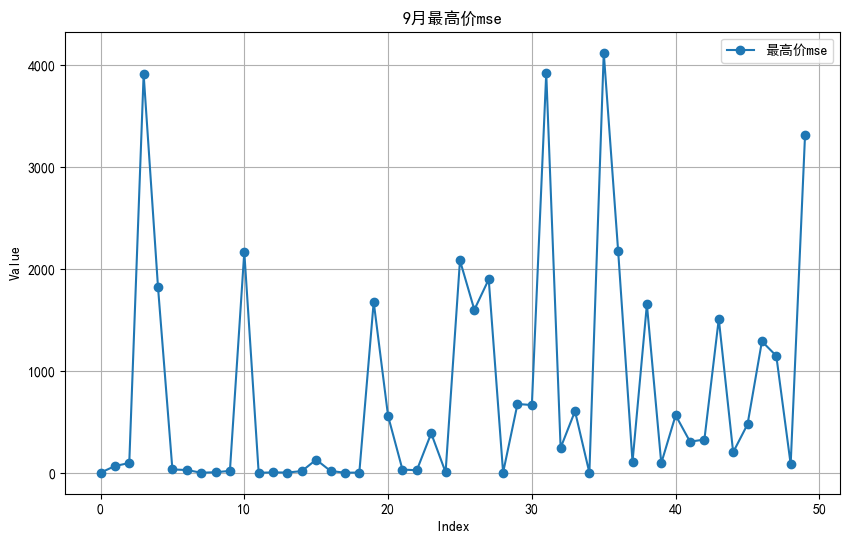

In [36]:
tmp = []
for file in file_names:
    file_path = os.path.join('data', file)

    data = pd.read_csv(file_path)

    train_data, test_data = deal_data(data)

    y_train_high = train_data['最高']
    y_train_low = train_data['最低']
    y_test_high = test_data['最高']
    y_test_low = test_data['最低']

    X_train = train_data.drop(columns=['日期', '最高', '最低'])
    X_test = test_data.drop(columns=['日期', '最高', '最低'])

    # 使用训练好的模型进行预测
    y_pred_high = best_model_low.predict(X_test)

    mse = mean_squared_error(y_test_high, y_pred_high)
    print(f'{file} - Mean Squared Error: {mse}')
    tmp.append(mse)

plt.figure(figsize=(10, 6))
plt.plot(tmp, label='最高价mse', marker='o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('9月最高价mse')
plt.legend()
plt.grid(True)
plt.show()

可以看出mse很大，因为我们这个模型只用到一只股票的信息

接下来训练多个xgboost，进行软投票集成学习

(50支股票，每支训练一个xgboost)

## 模型融合

xgboost 软投票

In [37]:
def getModel(X_train, y_train_high, y_train_low):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

    grid_search_high = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
    grid_search_high.fit(X_train, y_train_high)
    grid_search_low = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
    grid_search_low.fit(X_train, y_train_low)

    return grid_search_high.best_estimator_, grid_search_low.best_estimator_

In [113]:
a = []
b = []
for file in file_names:
    file_path = os.path.join('data', file)

    data = pd.read_csv(file_path)

    train_data, test_data = deal_data(data)

    y_train_high = train_data['最高']
    y_train_low = train_data['最低']
    y_test_high = test_data['最高']
    y_test_low = test_data['最低']

    X_train = train_data.drop(columns=['日期', '最高', '最低'])
    X_test = test_data.drop(columns=['日期', '最高', '最低'])

    model_high, model_low = getModel(X_train, y_train_high, y_train_low)
    a.append(model_high)
    b.append(model_low)
    print(f'{file} fit over')

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
000016深康佳Ａ.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
000021深科技.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
000818航锦科技.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
001309德明利.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
002049紫光国微.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
002077大港股份.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each o

In [114]:
softvote_high = VotingRegressor(estimators=a)
softvote_low = VotingRegressor(estimators=b)

这个训练了150mins，保存一下模型

In [ ]:
joblib.dump(softvote_high, 'model/softvote_high.pkl')
joblib.dump(softvote_low, 'model/softvote_low.pkl')

In [38]:
softvote_low = joblib.load('model/softvote_low.pkl')
softvote_high = joblib.load('model/softvote_high.pkl')

In [39]:
tmp = []
j = 0
for i in softvote_high.estimators:
    tmp.append(('tmp' + str(j), i))
    j += 1
softvote_high = VotingRegressor(estimators=tmp)

In [40]:
tmp = []
j = 0
for i in softvote_low.estimators:
    tmp.append(('tmp' + str(j), i))
    j += 1
softvote_low = VotingRegressor(estimators=tmp)

验证模型

In [41]:
all_mse = [0, 0]
list_mse_high = []
list_mse_low = []

for file in file_names:
    file_path = os.path.join('data', file)

    data = pd.read_csv(file_path)

    train_data, test_data = deal_data(data)

    y_train_high = train_data['最高']
    y_train_low = train_data['最低']
    y_test_high = test_data['最高']
    y_test_low = test_data['最低']

    X_train = train_data.drop(columns=['日期', '最高', '最低'])
    X_test = test_data.drop(columns=['日期', '最高', '最低'])


    # 使用训练好的模型进行预测
    softvote_high.fit(X_train, y_train_high)
    y_pred_high = softvote_high.predict(X_test)

    softvote_low.fit(X_train, y_train_low)
    y_pred_low = softvote_low.predict(X_test)

    mse_high = mean_squared_error(y_test_high, y_pred_high)
    mse_low = mean_squared_error(y_test_low, y_pred_low)
    print(f'{file[:-4]}: {mse_high}, {mse_low}')
    all_mse[0] += mse_high
    all_mse[1] += mse_low
    list_mse_high.append(mse_high)
    list_mse_low.append(mse_low)

print(f'all_mse(high, low) = {all_mse}')

000016深康佳Ａ: 0.0016151321339640402, 0.000858212985456207
000021深科技: 0.0026191422745941214, 0.002926528780834547
000818航锦科技: 0.951336025068976, 0.8656483627770596
001309德明利: 0.20736393514016435, 0.10090400275215752
002049紫光国微: 0.3175427441915109, 0.10945592648425792
002077大港股份: 0.0018958094173129676, 0.001597212339946681
002119康强电子: 0.0034241283267682217, 0.002094963624506207
002183怡亚通: 0.0008620684972772676, 0.0012932928233144443
002185华天科技: 0.0014531714089914332, 0.001128505766583364
002213大为股份: 0.002591066957870244, 0.0033447033559627568
002409雅克科技: 0.0656018237758117, 0.07926712540323015
002413雷科防务: 0.0004678042339971519, 0.00012298186943778894
002559亚威股份: 0.0015145449613919316, 0.0021435790512991573
002579中京电子: 0.001593323649041784, 0.001336569982978412
002654万润科技: 0.003150276985342669, 0.002552734521692566
300042朗科科技: 0.14365613920801545, 0.023397346823726274
300053航宇微: 0.0032836295716291543, 0.0037152318315100954
300131英唐智控: 0.0010669222108471844, 0.007204378728829198
300184力源信息: 

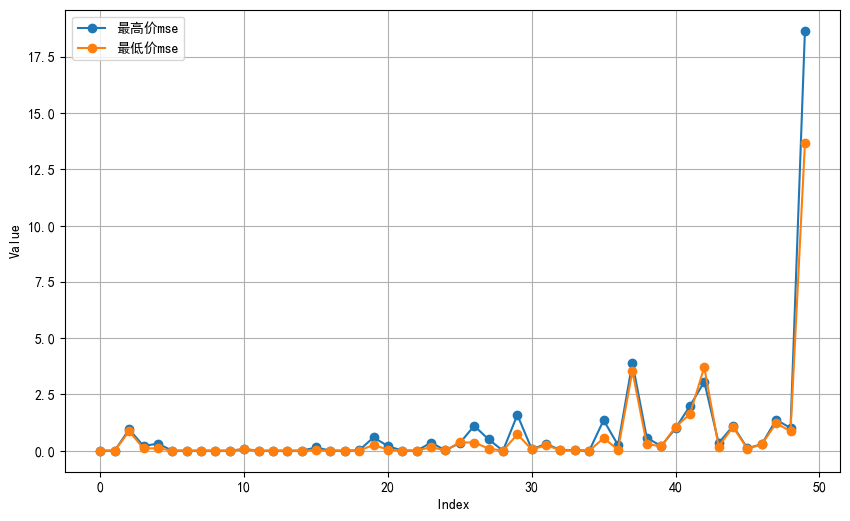

In [42]:
def plot_comparison(arrayList, labelList, title=None):
    plt.figure(figsize=(10, 6))
    for array, label in zip(arrayList, labelList):
        plt.plot(array, label=label, marker='o')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_comparison([list_mse_high, list_mse_low], ['最高价mse', '最低价mse'])

## 9月股票特征预测问题

我们预测9月股票最高最低价时使用了其他特征，按常识这些特征是未知的，需要从先前的数据中预测

下面使用自回归预测特征

In [43]:
def feature_pred(X_train, X_test):
    from statsmodels.tsa.ar_model import AutoReg

    # 确保数据按时间顺序排列
    X_train = X_train.sort_index(ascending=False)
    X_test = X_test.sort_index(ascending=False)

    # 使用自回归模型预测
    predictions = []

    for col in X_train.columns:
        model = AutoReg(X_train[col], lags=1)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)
        predictions.append(pred)

    # 将预测结果转换为 DataFrame
    predicted_X_test = pd.DataFrame(np.array(predictions).T, columns=X_train.columns)

    return predicted_X_test

输出 `最低价mse` `最高价mse` `预测特征mse`

In [44]:
all_mse_new = [0, 0]
list_mse_high_new = []
list_mse_low_new = []
list_mse_feature = []

for file in file_names:
    file_path = os.path.join('data', file)

    data = pd.read_csv(file_path)

    train_data, test_data = deal_data(data)

    y_train_high = train_data['最高']
    y_train_low = train_data['最低']
    y_test_high = test_data['最高']
    y_test_low = test_data['最低']

    X_train = train_data.drop(columns=['日期', '最高', '最低'])
    X_test_t = test_data.drop(columns=['日期', '最高', '最低'])

    # 预测特征
    X_test = feature_pred(X_train, X_test_t)

    # 使用训练好的模型进行预测
    softvote_high.fit(X_train, y_train_high)
    y_pred_high = softvote_high.predict(X_test)

    softvote_low.fit(X_train, y_train_low)
    y_pred_low = softvote_low.predict(X_test)

    mse_high = mean_squared_error(y_test_high, y_pred_high)
    mse_low = mean_squared_error(y_test_low, y_pred_low)
    mse_feature = mean_squared_error(X_test, X_test_t)
    print(f'{file[:-4]}: {mse_high}, {mse_low}, {mse_feature}')
    all_mse_new[0] += mse_high
    all_mse_new[1] += mse_low
    list_mse_high_new.append(mse_high)
    list_mse_low_new.append(mse_low)
    list_mse_feature.append(mse_feature)

print(all_mse_new)

c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

000016深康佳Ａ: 0.04762879507495232, 0.0565347138172099, 1.5430755313872935


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

000021深科技: 0.27030797326091327, 0.1982067276292339, 0.1553176169470183


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

000818航锦科技: 1.2134931277610252, 0.8719358074277511, 0.12887867588326174


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

001309德明利: 93.10877908208246, 48.99989923570828, 0.9858845139646739


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002049紫光国微: 8.55355869455649, 4.769954058577023, 0.7996241998235601


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002077大港股份: 0.553366983408645, 0.2843086094275481, 0.5940578919939793


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002119康强电子: 0.5054492728701239, 0.27814966429748006, 0.404624705029069


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002183怡亚通: 0.11207749464485411, 0.0686340045722433, 1.8414789230035813


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002185华天科技: 0.30186216984022546, 0.25444837193828285, 0.19362489045107759


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002213大为股份: 0.20714547877103548, 0.1374779423382967, 0.24404479046283625


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002409雅克科技: 24.473972978942548, 20.039730035156037, 0.5536847984581239


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002413雷科防务: 0.018994265292617267, 0.016199340733121487, 0.37860086730892306


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002559亚威股份: 0.18784945290259902, 0.10630100938445843, 0.3764767088266662


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002579中京电子: 0.24124611959507314, 0.1697152231395214, 0.4276194817780733


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

002654万润科技: 0.6356809680083573, 0.2493831484380943, 0.3899966830838829


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300042朗科科技: 2.6353420433466717, 1.1557860178025592, 0.27282406687787514


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300053航宇微: 0.23446939647971796, 0.12123645821214983, 0.10315045280099484


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300131英唐智控: 0.16229360830569836, 0.10643384466963836, 0.5200373994893182


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300184力源信息: 0.9673148911375163, 0.7255477164540687, 0.9715329102133788


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300223北京君正: 7.271570744754028, 2.413925525578226, 0.6597180554699111


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300236上海新阳: 3.5630122176704635, 3.2756733192591616, 0.3912020019284356


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300302同有科技: 0.5130010760404455, 0.33844934915304203, 0.17382554714786644


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300455航天智装: 0.3733814441570336, 0.1830798160161911, 0.1476298288482423


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300475香农芯创: 6.408793972298052, 4.169975717319778, 0.27313437615202096


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300551古鳌科技: 1.6137074472011816, 1.1432822937494325, 1.1545068882556506


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300567精测电子: 60.61836094336801, 56.7401176851898, 0.7568440468757505


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300672国科微: 10.971396840851627, 4.760966814778754, 0.6141346186634661


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300857协创数据: 34.32657330824157, 22.593975125804224, 0.6317003587409241


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300903科翔股份: 0.08124412283609628, 0.053713909861746116, 0.14611387724897168


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

301099雅创电子: 14.315984585219846, 8.808945461649767, 0.3778224817732036


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

301306西测测试: 5.562610582333406, 3.7196401224095954, 0.198434418740657


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

301308江波龙: 70.38051535481117, 44.16712457014221, 0.9671273720322467


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

600171上海贝岭: 1.211421889216271, 0.6750274579696088, 0.19082610244839976


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

600584长电科技: 7.531274586112237, 7.078202912235827, 0.16570070678336177


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

600667太极实业: 0.1191906616233078, 0.0679650166550913, 0.3441244257095322


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

603986兆易创新: 36.33565612377518, 22.612721590261955, 0.9182446449937506


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688008澜起科技: 8.781725983626064, 6.00109836631126, 0.5062850298497977


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688110东芯股份: 5.658311044054596, 4.804084431280294, 0.32058296331601077


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688123聚辰股份: 18.74979135381402, 15.732812064659347, 0.45891504114225795


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688262国芯科技: 0.5058463287300411, 0.3807224762599704, 0.2789224942074863


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688347华虹公司: 6.196138718908978, 5.225265567166819, 0.3562976896720764


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688416恒烁股份: 3.459114428244341, 2.857757160767224, 0.3021649948483534


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688478晶升股份: 6.268493791505966, 4.748818056905582, 0.38992767607486806


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688525佰维存储: 32.231762741084694, 18.299356562791885, 0.5651059116544959


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688589力合微: 1.9736778845238352, 1.6640992213405907, 0.3567874132891225


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688611杭州柯林: 3.939227888260452, 4.253305749553798, 0.2641934884015354


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688627精智达: 21.235218433632653, 13.2490672923972, 0.6854610497750766


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688652京仪装备: 18.89528435282396, 14.05021437561583, 0.47210519529851064


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688709成都华微: 1.2230005012344807, 0.7066459106344883, 0.4807940643963414


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

688766普冉股份: 62.11115753734207, 36.33400767799201, 0.8924780643668881
[586.8572796845777, 389.7199235314337]


mse可视化

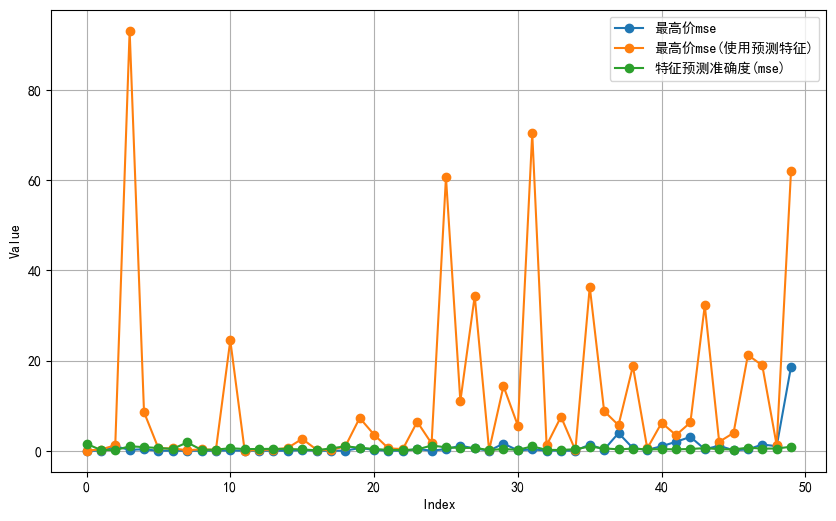

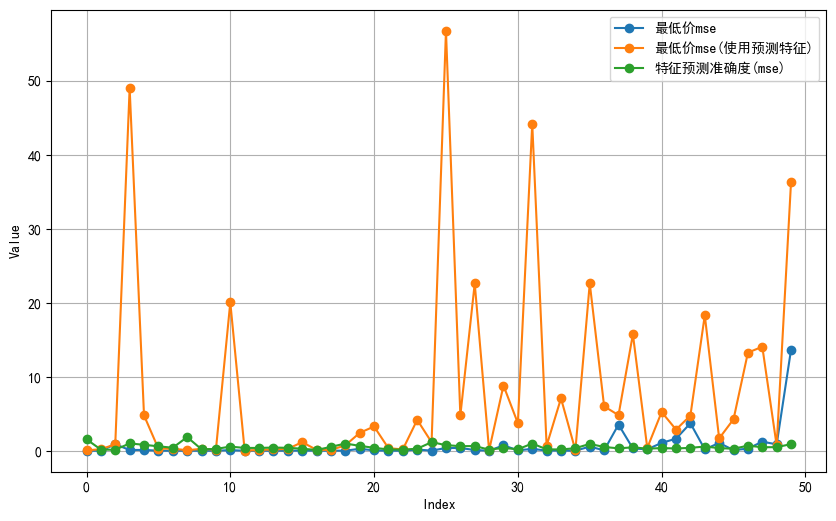

In [45]:
plot_comparison([list_mse_high, list_mse_high_new, list_mse_feature],
                 ['最高价mse', '最高价mse(使用预测特征)', '特征预测准确度(mse)'])
plot_comparison([list_mse_low, list_mse_low_new, list_mse_feature],
                 ['最低价mse', '最低价mse(使用预测特征)', '特征预测准确度(mse)'])

In [46]:
print(f'总mse对比: {all_mse}(使用爬取的正确特征), {all_mse_new}(使用预测特征)')

总mse对比: [42.119561329115726, 31.98798840972605](使用爬取的正确特征), [586.8572796845777, 389.7199235314337](使用预测特征)


既然特征可以预测，那用时间序列预测 `最高价` 和 `最低价` 如何？

 还是自回归

In [47]:
def autoReg(X_train, X_test):
    from statsmodels.tsa.ar_model import AutoReg

    # 确保数据按时间顺序排列
    X_train = X_train.sort_index(ascending=False)
    X_test = X_test.sort_index(ascending=False)

    # 使用自回归模型预测
    predictions = []

    model = AutoReg(X_train, lags=1)
    model_fit = model.fit()
    pred = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)
    predictions.append(pred)

    # 将预测结果转换为 DataFrame
    predicted_X_test = pd.DataFrame(np.array(predictions).T, columns=[X_train.name])

    return predicted_X_test

list_mse_low2 = []
list_mse_high2 = []

for file in file_names:
    file_path = os.path.join('data', file)

    data = pd.read_csv(file_path)

    train_data, test_data = deal_data(data)

    y_train_high = train_data['最高']
    y_train_low = train_data['最低']
    y_test_high = test_data['最高']
    y_test_low = test_data['最低']

    X_train = train_data.drop(columns=['日期', '最高', '最低'])
    X_test = test_data.drop(columns=['日期', '最高', '最低'])

    y_pred_high = autoReg(y_train_high, y_test_high)
    y_pred_low = autoReg(y_train_low, y_test_low)

    high = mean_squared_error(y_test_high, y_pred_high)
    low = mean_squared_error(y_test_low, y_pred_low)
    print(f'{file[:-4]} mse_high: {high}')
    print(f'{file[:-4]} mse_low: {low}')

    list_mse_high2.append(high)
    list_mse_low2.append(low)


000016深康佳Ａ mse_high: 0.04930641319194735
000016深康佳Ａ mse_low: 0.02714403874444617
000021深科技 mse_high: 0.3363243807126492
000021深科技 mse_low: 0.26116201457903543
000818航锦科技 mse_high: 1.4366823831938362
000818航锦科技 mse_low: 0.916424731465739
001309德明利 mse_high: 85.26743853165723
001309德明利 mse_low: 61.54618145102357
002049紫光国微 mse_high: 8.25362989916183
002049紫光国微 mse_low: 4.867561418058649
002077大港股份 mse_high: 1.0443500334840787
002077大港股份 mse_low: 0.6489736991497415
002119康强电子 mse_high: 0.615539939062972
002119康强电子 mse_low: 0.3677637499541034
002183怡亚通 mse_high: 0.10536938266609319
002183怡亚通 mse_low: 0.0815263786458234
002185华天科技 mse_high: 0.27431085242436104
002185华天科技 mse_low: 0.20396445829409587
002213大为股份 mse_high: 0.3677055231442161
002213大为股份 mse_low: 0.1744088402226717
002409雅克科技 mse_high: 26.697889471059856
002409雅克科技 mse_low: 17.464399994865154
002413雷科防务 mse_high: 0.02744898190409091
002413雷科防务 mse_low: 0.018293089314329505
002559亚威股份 mse_high: 0.17995640520087872
002559亚威股份 mse_

c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

300475香农芯创 mse_high: 5.429746148751571
300475香农芯创 mse_low: 3.9565650385080997
300551古鳌科技 mse_high: 1.7759709203618024
300551古鳌科技 mse_low: 0.967563694825518
300567精测电子 mse_high: 55.74535435074571
300567精测电子 mse_low: 61.381071956523215
300672国科微 mse_high: 16.280002184162313
300672国科微 mse_low: 2.566574071478843
300857协创数据 mse_high: 22.663798438168705
300857协创数据 mse_low: 10.865291081709042
300903科翔股份 mse_high: 0.070163958042014
300903科翔股份 mse_low: 0.04219486030645723
301099雅创电子 mse_high: 14.96274337307947
301099雅创电子 mse_low: 8.511846296960051


c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

301306西测测试 mse_high: 9.783305089149964
301306西测测试 mse_low: 3.0933233824571253
301308江波龙 mse_high: 78.34170790202424
301308江波龙 mse_low: 50.25179022961484
600171上海贝岭 mse_high: 1.0992208306268596
600171上海贝岭 mse_low: 1.499238655903616
600584长电科技 mse_high: 8.073404765705694
600584长电科技 mse_low: 3.2579743690190224
600667太极实业 mse_high: 0.12856420757209552
600667太极实业 mse_low: 0.08494553002279387
603986兆易创新 mse_high: 40.82013071831482
603986兆易创新 mse_low: 27.618499263356924
688008澜起科技 mse_high: 8.639210925725996
688008澜起科技 mse_low: 4.835763715964518
688110东芯股份 mse_high: 7.477918115748155
688110东芯股份 mse_low: 5.762519755395334
688123聚辰股份 mse_high: 21.622113985866488
688123聚辰股份 mse_low: 10.092342207495188
688262国芯科技 mse_high: 0.6284004764495947
688262国芯科技 mse_low: 0.3109877024533332
688347华虹公司 mse_high: 9.995634309202185
688347华虹公司 mse_low: 3.869912106090507
688416恒烁股份 mse_high: 17.1952766898188
688416恒烁股份 mse_low: 7.920848233181973
688478晶升股份 mse_high: 8.576112132650008
688478晶升股份 mse_low: 5.954492

c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chen\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

该方法，预测出的 `最高价` 和 `最低价` 如下

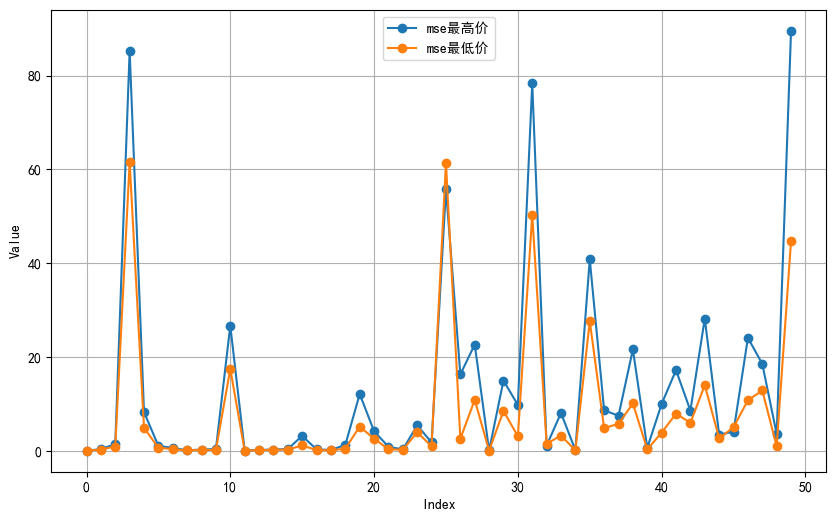

In [48]:
plot_comparison([list_mse_high2, list_mse_low2], ['mse最高价', 'mse最低价'])

现在总结一下，我们搞了三种方法

1. 爬取的 X 预测 y  
   很准确，但是按照常理，我们不能预先知道 X

2. 用时间序列预测（自回归）预测 X，再预测 y  
   准确度下降
   
3. 直接用时间序列预测（自回归）预测 y  
   准确度再下降

**可以在下图中看出三者mse： 3 > 2 > 1**


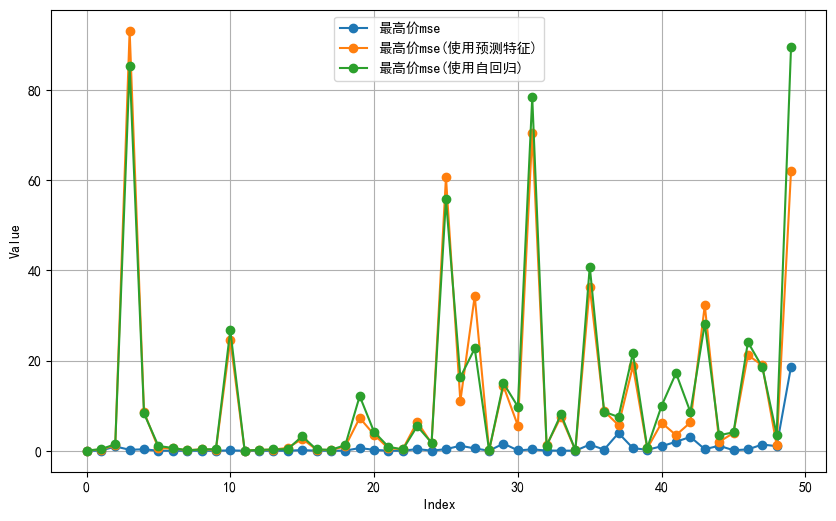

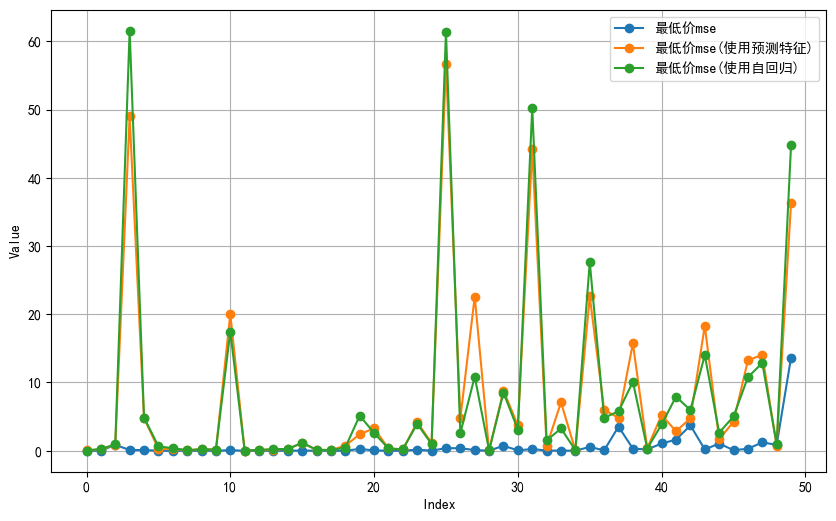

In [49]:
plot_comparison([list_mse_high, list_mse_high_new, list_mse_high2],
                 ['最高价mse', '最高价mse(使用预测特征)', '最高价mse(使用自回归)'])
plot_comparison([list_mse_low, list_mse_low_new, list_mse_low2],
                 ['最低价mse', '最低价mse(使用预测特征)', '最低价mse(使用自回归)'])

三种方法 `总mse`

In [50]:
all_mse2 = [np.array(list_mse_high2).sum(), np.array(list_mse_low2).sum()]

In [51]:
all_mse, all_mse_new, all_mse2

([42.119561329115726, 31.98798840972605],
 [586.8572796845777, 389.7199235314337],
 [648.4114688861182, 401.25718507531445])

``平均mse`` (50支股票)

In [52]:
(np.array([all_mse, all_mse_new, all_mse2])/50).tolist()

[[0.8423912265823145, 0.639759768194521],
 [11.737145593691555, 7.794398470628675],
 [12.968229377722365, 8.02514370150629]]